# CS440/ECE448 Spring 2023
# MP05: Search

The first thing you need to do is to download this file: <a href="mp05.zip">mp05.zip</a>.  It has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp05_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `data`: This directory contains the data.
* `tests`: This directory contains visible test.
* `grade.py`: This file contains the programs to run your solution on visible tests
* `main.py`: This file will be the primary entry point for this assignment. You can try to open a pygame-based interactive visualization of the data/part-1/small maze utilizing the command 'python3 main.py --human data/part-1/small'. Similarily, you can also play with other maze by changing the file name after data/

You will need to import [pygame](https://www.pygame.org/news). Otherwise, you should use only modules from the [python standard library](https://docs.python.org/3/library/).

This file (`mp05_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Goal
In this assignment, you will implement general-purpose search algorithms and use them to solve pacman-like maze puzzles. Throughout this assignment, the goal will be to find a path from the starting position to a single destination waypoint by implementing two functions utilizing different search strategies. 

This assignment is written in Python 3. Here is the tutorial for <a href="https://docs.python.org/3/tutorial/">Python</a> if you want to get famaliar with it. We recommend using Python version 3.8 or later. 

This assignment contains visualization tools which depend on <a href="https://www.pygame.org/news">pygame</a>. You can install pygame locally using the <a href="https://pip.pypa.io/en/stable/">pip3</a> tool.

### Table of Contents

1. <a href="#section1">Understand Maze</a>
1. <a href="#section2">Maze API</a>
1. <a href="#section3">BFS</a>
1. <a href="#section4">A*</a>
1. <a href="#grade">Grade Your Homework</a>
1. <a href="#extra">Extra Credit</a>
1. <a href="#extra">Tools</a>

<a id='section1'></a>
## Understand Maze

This section aims to help you get some ideas of the data we are using. Note that in this MP we have provided the maze for you, so you don't need to write maze on your own. The data/ directory contains the maze files we will be using in this assignment. Image shown below is what the maze will look at after openning a pygame-based interactive visualization of the data/part-1/small maze and a solution from the start point to the end point.

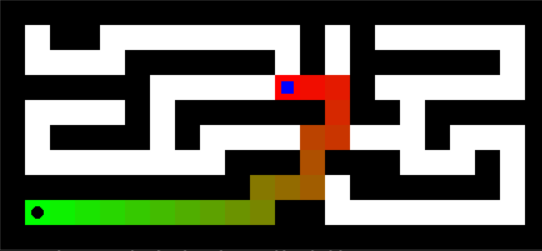

<b>Hint:</b> This is what the solution will look when you run bfs of A* single_search.

The blue dot represents the agent. You can move the agent, using the arrow keys, to trace out a path, shown in color. The black dots represent the maze waypoints. Observe that this maze contains a single waypoint, in the lower left-hand corner. 

Let's play with the maze by running the cell shown below (If your environment does not recognize python3 or giving you an error, try python instead first in the following command. Please also make sure you have installed all the dependencies.)

In [37]:
!python3 main.py --human data/part-1/small

pygame 2.2.0 (SDL 2.0.22, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


<a id='section2'></a>
## Maze API

It is helpful to understand some of the infrastructure we have provided in the starter code. All the important functions and variables you should use can be found in maze.py. The Maze class is the abstraction that converts the input ASCII mazes into something whose properties you can access straightforwardly.

You can inspect the ASCII maze cells programatically using the \__getitem__ ( _: _:) subscript.

cell = maze[row, column] 

<b>Warning</b>: this subscript uses matrix notation, meaning the first index is the row, not the column. Spatially, this means the y-coordinate comes before the x-coordinate. In the rest of this guide, we will use i to refer to a row index, and j to refer to a column index.

The maze size is given by the size member. The size.x value specifies the number of columns in the maze, and the size.y value specifies the number of rows in the maze.

<b>rows    = maze.size.y <br> </b>
<b>columns = maze.size.x </b>

Keep in mind that the coordinate order in size is reversed with respect to the two-dimensional indexing scheme!
Each cell in the maze is represented by a single character of type str. There are four kinds of cells, which should be self-explanatory:
* <b>wall cells</b>
* <b>start cells</b>
* <b>waypoint cells</b>
* <b>empty cells</b>

For this MP, there would be just only one starting point and one waypoint point. What is more, you can determine what kind of cell a particular maze cell is by using the maze legend, available in the legend property. Code cells below import the maze with the picture shown above, and they give you an idea of how to determine the type of a cell at a certain position. You can also assume that any cell that is not a wall, start position, or waypoint is empty.

In [52]:
import maze

In [53]:
maze1 = maze.Maze('data/part-1/small')

In [54]:
print(maze1[0, 0] == maze1.legend.wall)
print(maze1[1, 1] == maze1.legend.wall)
print(maze1[3, 11] == maze1.legend.start)
print(maze1[8, 1] == maze1.legend.waypoint)

True
False
True
True


The Maze type also supports the following interfaces with detailed comment and usage shown below, which may or may not be useful to you when you try to debug your code:

In [55]:
# Coordinate of the starting position
print(maze1.start)

# Coordinate of the waypoint position
print(maze1.waypoints)

(3, 11)
((8, 1),)


In [56]:
# A generator traversing the coordinates of all the cells in the maze, in row-major order"
print(list(maze1.indices()))

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5,

In [57]:
# Takes (i, j) coordinates (as separate arguments), and returns a bool indicating 
# if the corresponding cell is navigable (meaning the agent can move into it). 
# All cells except for wall cells are navigable.
print(maze1.navigable(1, 1))

True


In [58]:
# Takes (i, j) coordinates (as separate arguments), and returns a tuple containing a sequence 
# of the coordinates of all the navigable neighbors of the given cell. A cell can have at most 4 neighbors.
print(maze1.neighbors(3, 11))

((2, 11), (3, 12), (3, 10))


In [59]:
# Keeps track of the number of cells visited in this maze. Each call to neighbors(_:_:) 
# increments this value by 1. We will utilize this value to test if you are expanding 
#the correct number of states, so do not call neighbors(_:_:) any more than necessary.
print(maze1.states_explored)
print(maze1.neighbors(3, 12))
print(maze1.states_explored)

1
((3, 13), (3, 11))
2


In [60]:
# Validates a path through the maze. This method returns None if the path is valid, 
# and an error message of type str otherwise.

path = [(3,11), (3,12), (3,13)]
print(maze1.validate_path(path))

last path vertex 2 (3, 13) must be a waypoint


<a id='section3'></a>
## BFS

The first function we will need to implement is the breadth-first search (BFS) for a single waypoint. Specifically, we will implement a function bfs(_:) in `submitted.py`. Let's have a quick recap.

<img src="./GIF/bfs.gif" width="750" align="center">

The automation was created at this <a href="https://qiao.github.io/PathFinding.js/visual/">website</a>. Feel free to play around with it.

In the animation shown above, we are utilizing the BFS method to find a path from the start point(Dark Green Point) to the waypoint(Red Point). Grey Points represent walls, blue points are nodes that have been explored, and light green points are the frontiers. It is easy to see that BFS method will try to search/visit all frontiers at the current depth level before moving on to the frontiers at the next depth level. 


In order to implement BFS (and, later on, A*), you will need to think carefully about the data structures you are using.  

1. To implement the frontier, you may want to use a [Queue](https://docs.python.org/3/library/queue.html).  For BFS, you'll want to use a FIFO queue.  For A*, you'll want to use a PriorityQueue.
1. You may also want to use an "explored set," which is a [set](https://docs.python.org/3/library/stdtypes.html#set-types-set-frozenset) where you keep track of the states you have expanded.

Unfortunately, both of these data structures place some limitations on the types of things you put into them.  Things you put into a PriorityQueue must be sortable.  Things you put into a set must be hashable.  There are two ways you can do this:

1. You can create a new class of objects, and make it both sortable and hashable.  The requirements for a class to be sortable and hashable are listed [here](https://stackoverflow.com/questions/7152497/making-a-python-user-defined-class-sortable-hashable).
1. Instead of creating your own new class of objects, you can just use tuples.  Tuples are always hashable, and the rules for sorting of tuples are listed [here](https://stackoverflow.com/questions/644170/how-does-python-sort-a-list-of-tuples).  Note that the syntax for creating single-element tuples is weird ([see this page](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences)), and the easiest way to concatenate two tuples is to use the `+` operator ([see this page](https://stackoverflow.com/questions/10459324/concatenating-tuple)); we recommend you test your ideas in an interactive window before writing your `submitted.py`.

At this point, we'll load the file `submitted.py`.

The file `submitted.py` is the only part of your work that the autograder will see. The only purpose of this notebook is to help you debug `submitted.py`.  Once you have revised `submitted.py` enough to make this notebook work, then you should go to the command line, and type `python grade.py`.  Once that command returns without errors, then  you can go ahead and submit your file `submitted.py` to the autograder.  You can submit to the autograder as often as you want, but it will save you trouble if you debug as much as you can on your local machine, before you submit to the autograder.

We will use `importlib` in order to reload your `submitted.py` over and over again.  That way, every time you make a modification in `submitted.py`, you can just re-run  the corresponding block of this notebook, and it will reload `submitted.py` with your modified code.  

Since the file is called `submitted.py`, python considers it to contain a module called `submitted`.  As shown, you can read the module's docstring by printing `submitted.__doc__`.  You can also type `help(submitted)` to get a lot of information about the module, including its docstring, a list of all the functions it defines, and all of their docstrings.  For  more about docstrings, see, for example, https://www.python.org/dev/peps/pep-0257/.

In [61]:
import submitted
import importlib
importlib.reload(submitted)
print(submitted.__doc__)


This is the main entry point for MP5. You should only modify code
within this file -- the unrevised staff files will be used for all other
files and classes when code is run, so be careful to not modify anything else.



In [62]:
help(submitted.bfs)

Help on function bfs in module submitted:

bfs(maze)
    Runs BFS for part 1 of the assignment.
    
    @param maze: The maze to execute the search on.
    
    @return path: a list of tuples containing the coordinates of each state in the computed path



In [63]:
importlib.reload(submitted)
path = submitted.bfs(maze1)
print(path)

[(3, 11), (3, 12), (3, 13), (4, 13), (5, 13), (5, 12), (6, 12), (7, 12), (7, 11), (7, 10), (8, 10), (8, 9), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (8, 1)]


You can also visualize your path by running the code shown below. Similarily, you can also run on other mazes by changing the file name after data/

In [64]:
!python3 main.py data/part-1/small --search bfs

pygame 2.2.0 (SDL 2.0.22, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html

Results 
{
    path length         : 20
    states explored     : 92
    total execution time: 0.00 seconds
}
            


Compare your image shown with the image shown at section <a href="#section1">Understand Maze</a>. Make sure you get the correct answer before moving to the next part.

<a id='section4'></a>
## A* for single waypoint

For this part of the assignment, you are going to solve the same set of mazes as in the previous part, this time using the A* search algorithm. Write your implementation as a function astar_single(_:) in `submitted.py`

A* search is also one of the most popular techniques used in path finding and graph traversals. What makes A* search algorithm powerful is that at each step it picks the node to explore in the next step based on `f` value, which is the sum of two other parameters - `g` and `h`. At each step, it picks the node with lowest `f` value, and process that node/cell.  

In python, a priority queue can be implemented using the [queue.PriorityQueue](https://docs.python.org/3/library/queue.html) class.

We define `g` and `h` as following.

`g` = the movement cost to move from the starting point to a given square on the grid, following the path generated to get there. 

`h` = the estimated movement cost to move from that given square on the grid to the final destination. This is often referred to as the heuristic, which is nothing but a kind of smart guess. We really don’t know the actual distance until we find the path, because all sorts of things can be in the way (walls, water, etc.).  If the heuristic is admissible, then A* search is optimal.

You can use the Manhattan Distance from the agent's current position to the singular waypoint as the A* heuristic function. For two grid coordinates a and b, the manhattan distance is given by:

<b> abs(a[0] - b[0]) + abs(a[1] - b[1]) </b>

<img src="./GIF/Astar.gif" width="750" align="center">

The automation was created at this <a href="https://qiao.github.io/PathFinding.js/visual/">website</a>. Feel free to play around with it, and also try some different Heuristic Function.

In the animation shown above, we are utilizing the A* method to find a path from the start point(Green Point) to the waypoint(Red Point) using Manhattan Distance as Heuristic function. Again, grey Points are represented as walls, blue points are nodes that have been explored, and light green points are the frontiers.

<b> Note: </b> You should find that the path lengths returned by A* are the same as those computed by breadth-first search in this case, but A* explores much fewer states.

Let's see the docstring about the astar_single function.

In [65]:
help(submitted.astar_single)

Help on function astar_single in module submitted:

astar_single(maze)
    Runs A star for part 2 of the assignment.
    
    @param maze: The maze to execute the search on.
    
    @return path: a list of tuples containing the coordinates of each state in the computed path




Your astar_single(_:) implementation should return a maze path, which should be a sequence of (i, j) coordinates. 
The first vertex of the path should be start, and the last vertex should be waypoints[0]. Here is the example of the path you will get when you run on the small maze as shown in the section <a href="#section1">Understand Maze</a>. 

<b> Remainder: </b>  Replace data/part-1/ to data/part-2/ as needed

In [66]:
importlib.reload(submitted)
maze2 = maze.Maze('data/part-2/small')
path = submitted.astar_single(maze2)
print(path)

[(3, 11), (3, 12), (3, 13), (4, 13), (5, 13), (5, 12), (6, 12), (7, 12), (7, 11), (7, 10), (8, 10), (8, 9), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (8, 1)]


You can also visualize your path by running the code shown below. Similarily, you can also run on other mazes by changing the file name after data/

In [67]:
!python3 main.py data/part-2/small --search astar_single

pygame 2.2.0 (SDL 2.0.22, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html

Results 
{
    path length         : 20
    states explored     : 53
    total execution time: 0.00 seconds
}
            


Compare your image shown with the image shown at section <a href="#section1">Understand Maze</a>. Make sure you get the correct answer before moving to the next part.

<a id='extra'></a>
## Extra Credit

<b> Note: </b> Extra Credit Part is only worth 10 points and it is harder than previous two sections, so make sure you get all points from previous sections before doing this part.

Now, consider the more general and harder problem of finding the shortest path through a maze while hitting multiple waypoints. As suggested in Part 1, your state representation, goal test, and transition model should already be adapted to deal with this scenario. The next challenge is to solve different mazes using A* search with an appropriate admissible heuristic that takes into account the multiple waypoints.

In the past, one popular approach that has been taken is what we refer to as the "greedy" method, that is to greedily choose the closest waypoint to the current position, run A* on it, and repeat until all waypoints have been reached. Why is this suboptimal? Think about what happens if the nearest waypoint is in the center of a long line of waypoints. Clearly, this strategy will not always choose the best path.

Instead, there is a beautiful heuristic that will not only find the optimal path through all the waypoints, but is admissable as well. It is based on a data structure you hopefully have seen before: the Minimum Spanning Tree (MST). Instead of computing the distances to each waypoint from the current position, it would be more helpful to obtain an estimate of the cost of reaching the rest of the unreached waypoints once we have reached one. Obtaining this estimate can be done with an MST: by constructing a graph where the vertices are the waypoints and each edge connecting w_i to w_j has weight manhattan_distance(w_i, w_j) for all pairs of vertices (w_i, w_j), the MST represents the approximate lowest cost path that connects all the waypoints. Since it strictly underestimates the cost of going through all the waypoints, this is an admissable heuristic.

So, suppose you are in the middle of a search. You're at some location (x,y) with a set of S waypoints still to reach. Your heuristic function h should be the sum of the distance from (x,y) to the nearest waypoint, plus the MST length for the waypoints in S.

Write your implementation as a function astar_multiple(_:) in `submitted.py`.

In [42]:
help(submitted.astar_multiple)

Help on function astar_multiple in module submitted:

astar_multiple(maze)
    Runs A star for part 3 of the assignment in the case where there are
    multiple objectives.
    
    @param maze: The maze to execute the search on.
    
    @return path: a list of tuples containing the coordinates of each state in the computed path



<b> Remainder: </b>  Replace data/part-3/tiny to other mazes as needed, you can find them in /data folder

In [43]:
importlib.reload(submitted)
maze3 = maze.Maze('data/part-3/tiny')
path = submitted.astar_multiple(maze3)
print(path)

[]


You can also visualize your path by running the code shown below. Similarily, you can also run on other mazes by changing the file name after data/

<b> Tip: </b> This is what the solution should look like for the tiny maze if you do astar_multiple correctly
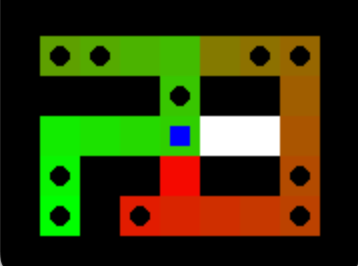

In [36]:
!python3 main.py data/part-3/tiny --search astar_multiple

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html

Results 
{
    path length         : 28
    states explored     : 1890
    total execution time: 0.01 seconds
}
            


<a id='section2'></a>

<a id='grade'></a>
## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases.

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

For the visible test, if you get full points for part 1 and part 2, you should get 60 points in total for completing bfs and astar_single functions. If you get full points for extra credit, you should get 5 points in total for completing astar_multiple function.

In [68]:
!python3 grade.py

running in student mode (instructor key unavailable)
{'tests': ({'max_score': 4,
            'name': "part-1: `validate_path(_:)` for 'tiny' maze",
            'output': 'Your path is valid',
            'score': 4,
            'visibility': 'visible'},
           {'max_score': 2,
            'name': "part-1: not too many states explored for 'tiny' maze",
            'output': 'You explored 15 states, you should explore fewer than '
                      '1.1 * 15',
            'score': 2,
            'visibility': 'visible'},
           {'max_score': 4,
            'name': "part-1: correct path length for 'tiny' maze",
            'output': 'Your path length is 9, the correct length is 9',
            'score': 4,
            'visibility': 'visible'},
           {'max_score': 4,
            'name': "part-1: `validate_path(_:)` for 'small' maze",
            'output': 'Your path is valid',
            'score': 4,
            'visibility': 'visible'},
           {'max_score': 2,
        

Now you should try uploading `submitted.py` to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

Gradescope will run the same visible tests that you just ran on your own machine, plus some additional hidden tests.  It's possible that your code passes all the visible tests, but fails the hidden tests.  If that happens, then it probably means that you hard-coded a number into your function definition, instead of using the input parameter that you were supposed to use.  Debug by running your function with a variety of different input parameters, and see if you can get it to respond correctly in all cases.

Once your code works perfectly on Gradescope, with no errors, then you are done with the MP.  Congratulations!

<a id='section4'></a>

<a id='grade'></a>